In [79]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from oneibl.onelight import ONE # only used for downloading data
# import wget
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject']).tolist()
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
colorsStates = ['darkblue','forestgreen','darkorange','purple']
myFeatures = [['bias','delta stimulus', 'previous choice', 'previous answer'],['bias','contrast left','contrast right', 'previous choice', 'previous answer']]
sns.set_context("talk")
colormap = ['rebeccapurple','teal','darkturquoise','springgreen','gold']

sigmaList = [0] + [10**x for x in list(np.arange(-3,1,0.5,dtype=float))] + [10**x for x in list(np.arange(1,4,1,dtype=float))]
L2penaltyW = 1
priorDirP = None
maxiter = 300
splitFolds = 5

D = 4 # number of features
sessStop = -1 # last session to use in fitting
subjectsAll = subjectsWitten

In [81]:
bestSigmaInd = 7 # equivalent to sigma=1
Kplot = [3,4] # K for which to plot parameters for each animal

allW = np.empty((len(subjectsAll), 4), dtype=object)
allP = np.empty((len(subjectsAll), 4), dtype=object)
testLlAll = np.zeros((4, len(subjectsAll), len(sigmaList)))
testAccuracyAll = np.zeros((4, len(subjectsAll), len(sigmaList)))
bestTestLl = np.zeros((4, len(subjectsAll)))
bestTestAccuracy = np.zeros((4, len(subjectsAll)))

for idx in [9]: #range(0, len(subjectsAll)):
    a = []
    subject = subjectsAll[idx]
    testLl = []
    testAccuracy = []
    avgTestLl = []
    avgTestAccuracy = []
    for K in [1,2,3,4]:
        data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
        # fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
        # fig.suptitle(f'{subject}')
        # for fold in range(0, splitFolds):
        #     plot_testLl_CV_sigma(data['testLl'][fold], sigmaList=sigmaList, label=f'K={K} fold {fold}', color=colormap[K-1], axes=axes)

        allP[idx,K-1] = np.mean(data['allP'], axis=0)
        allW[idx,K-1] = np.mean(data['allW'], axis=0)
        
        a.append(data['testLl'])
        avgTestLl.append(np.mean(data['testLl'],axis=0))
        avgTestAccuracy.append(np.mean(data['testAccuracy'],axis=0))
    # avgTestLl = [x - avgTestLl[0][0] for x in avgTestLl] # normalizing to GLM-HMM sigma=0 K=1
    # avgTestAccuracy = [x - avgTestAccuracy[0][0] for x in avgTestAccuracy]
    
    # for K in [1,2,3,4]:
    #     testLlAll[K-1][idx] = avgTestLl[K-1]
    #     testAccuracyAll[K-1][idx] = avgTestAccuracy[K-1]

    # bestSigmaInd = 7 # Choosing best sigma index across animals
    # for K in [1,2,3,4]:
    #     bestTestLl[K-1][idx] = avgTestLl[K-1][bestSigmaInd] - avgTestLl[0][bestSigmaInd] # delta
    #     bestTestAccuracy[K-1][idx] = avgTestAccuracy[K-1][bestSigmaInd] - avgTestAccuracy[0][bestSigmaInd] # delta

   

In [99]:
K = 4
x, y, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)
N = x.shape[0]
pi = np.ones((K))
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,2)
testL = np.zeros(((splitFolds),len(sigmaList)))
testL1 = np.zeros(((splitFolds),len(sigmaList)))
testAcc = np.zeros(((splitFolds),len(sigmaList)))
testAcc1 = np.zeros(((splitFolds),len(sigmaList)))
presentTrain, presentTest = split_data(N, sessInd, folds=splitFolds, blocks=10, random_state=1)
for sigmaInd in range(0,len(sigmaList)):
    for fold in range(0,splitFolds):
        data = np.load(f'../data_IBL/{subject}/{subject}_ALL-PARAM_D={D}_{K}-state_multiple-sigmas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npz')
        W = data['allW'][fold][sigmaInd] # fold 0, sigmaInd=7
        W1 = np.load(f'../data_IBL/{subject}/{subject}_W_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy')[sigmaInd]
        P = data['allP'][fold][sigmaInd]
        P1 = np.load(f'../data_IBL/{subject}/{subject}_P_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy')[sigmaInd]
        testL[fold][sigmaInd], testAcc[fold][sigmaInd] = dGLM_HMM.evaluate(x, y, sessInd, presentTest[fold], P, pi, W, sortStates=False)
        testL1[fold][sigmaInd], testAcc1[fold][sigmaInd] = dGLM_HMM.evaluate(x, y, sessInd, presentTest[fold], P1, pi, W1, sortStates=False)

# fig, axes = plt.subplots(D, 1,figsize=(16,4*D+1), sharex=True)
# fig.suptitle(f'{subject}, sigma = {np.round(sigmaList[bestSigmaInd],2)}')
# fig.tight_layout()
# plotting_weights_per_feature(-W, sessInd, axes, yLim=[[-2.5,2.5],[-0.5,8.2],[-2.5,2.5],[-2.5,2.5]], colors=colorsStates, labels=myFeatures[D%2], linewidth=2, linestyle='--', sortedStateInd=None)
# plotting_weights_per_feature(-W1, sessInd, axes, yLim=[[-2.5,2.5],[-0.5,8.2],[-2.5,2.5],[-2.5,2.5]], colors=colorsStates, labels=myFeatures[D%2], linewidth=2, linestyle='-', sortedStateInd=None)

print(testL)
print(testL1)


[[-0.44726276 -0.44124694 -0.43989292 -0.43287165 -0.42652819 -0.42455053
  -0.42537098 -0.42194857 -0.42176787 -0.42164817 -0.42139605 -0.42140634]
 [-0.45087048 -0.4445655  -0.44288327 -0.4347337  -0.42832178 -0.42582502
  -0.42615173 -0.42106906 -0.41989833 -0.41976978 -0.4197617  -0.41977618]
 [-0.45829985 -0.45281049 -0.45113671 -0.44246976 -0.43449742 -0.43198526
  -0.43339194 -0.42756332 -0.42705626 -0.42715242 -0.42717206 -0.42718164]
 [-0.45585752 -0.44944797 -0.44794068 -0.43960643 -0.43150366 -0.4281969
  -0.42765205 -0.42451098 -0.42360417 -0.42345146 -0.42352041 -0.42360669]
 [-0.45046732 -0.44674811 -0.44504575 -0.43609622 -0.4272602  -0.4242756
  -0.42523561 -0.42112326 -0.42040401 -0.42040343 -0.42041548 -0.42046647]]
[[-0.44726276 -0.44124694 -0.43989292 -0.43287165 -0.42652819 -0.42455053
  -0.42537098 -0.42194857 -0.42176787 -0.42164817 -0.42139605 -0.42140634]
 [-0.45087048 -0.4445655  -0.44288327 -0.4347337  -0.42832178 -0.42582502
  -0.42615173 -0.42106906 -0.4198

In [86]:
allW1 = np.empty((len(subjectsWitten), 4), dtype=object)
allP1 = np.empty((len(subjectsWitten), 4), dtype=object)
testLlAll1 = np.zeros((4, len(subjectsWitten), len(sigmaList)))
testAccuracyAll1 = np.zeros((4, len(subjectsWitten), len(sigmaList)))
bestTestLl1 = np.zeros((4,11))
bestTestAccuracy1 = np.zeros((4,11))


for idx in [9]:#range(0, len(subjectsWitten)):
    subject=subjectsWitten[idx]
    _, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

    testLl1 = []
    testAccuracy1 = []
    avgTestLl1 = []
    avgTestAccuracy1 = []
    a1 = []
    for K in [1,2,3,4]:
        a1.append(np.zeros((splitFolds,len(sigmaList))))
        for fold in range(0, splitFolds):
            a1[K-1][fold] = np.load(f'../data_IBL/{subject}/{subject}_testLl_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy')
            testLl1.append(np.load(f'../data_IBL/{subject}/{subject}_testLl_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
            testAccuracy1.append(np.load(f'../data_IBL/{subject}/{subject}_testAccuracy_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))   
        avgTestLl1.append(np.mean(testLl1[:],axis=0))
        avgTestAccuracy1.append(np.mean(testAccuracy1[:],axis=0))
    # avgTestLl1 = [x - avgTestLl1[0][0] for x in avgTestLl1] # normalizing to GLM-HMM sigma=0 K=1
    # avgTestAccuracy1 = [x - avgTestAccuracy1[0][0] for x in avgTestAccuracy1]
    
    # for K in [1,2,3,4]:
    #     testLlAll1[K-1][idx] = avgTestLl1[K-1]
    #     testAccuracyAll1[K-1][idx] = avgTestAccuracy1[K-1]

    # bestSigmaInd = 7 # Choosing best sigma index across animals
    # for K in [1,2,3,4]:
    #     bestTestLl1[K-1][idx] = avgTestLl1[K-1][bestSigmaInd] - avgTestLl1[0][bestSigmaInd] # delta
    #     bestTestAccuracy1[K-1][idx] = avgTestAccuracy1[K-1][bestSigmaInd] - avgTestAccuracy1[0][bestSigmaInd] # delta

    # for K in [1,2,3,4]:#,3,4]: #[1,2,3]:

    #     tempW = []
    #     tempP = []
    #     for fold in range(0, splitFolds):

    #         tempP.append(np.load(f'../data_IBL/{subject}/{subject}_P_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
    #         tempW.append(np.load(f'../data_IBL/{subject}/{subject}_W_D={D}_{K}_state_fold-{fold}_sigmas1D_L2penaltyW={L2penaltyW}_priorDirP={priorDirP}_untilSession{sessStop}.npy'))
        
    #     allP1[idx,K-1] = np.mean(tempP[:], axis=0)
    #     allW1[idx,K-1] = np.mean(tempW[:], axis=0)
            

In [87]:
print(a[0])
print(a1[0])

[[-0.52755526 -0.52519605 -0.50876285 -0.47939404 -0.46822531 -0.46117716
  -0.45675838 -0.45621557 -0.45622272 -0.45622685 -0.45622739 -0.45622736]
 [-0.52991826 -0.52761653 -0.51159062 -0.48248972 -0.47152075 -0.46372997
  -0.4583676  -0.45734654 -0.45724797 -0.45723858 -0.45723755 -0.45723756]
 [-0.53812099 -0.53568538 -0.51855247 -0.4875164  -0.47607598 -0.46761424
  -0.46177156 -0.46084337 -0.46083749 -0.46084231 -0.46084292 -0.46084293]
 [-0.53916224 -0.53685083 -0.52049331 -0.48935653 -0.47693028 -0.46959953
  -0.46611562 -0.46607738 -0.46616622 -0.46618062 -0.46618239 -0.46618233]
 [-0.53623007 -0.53376542 -0.5165753  -0.48318122 -0.46770722 -0.45815847
  -0.45344524 -0.45275984 -0.45269748 -0.45269284 -0.45269238 -0.45269236]]
[[-0.52755526 -0.52519605 -0.50876285 -0.47939404 -0.46822531 -0.46117716
  -0.45675838 -0.45621557 -0.45622272 -0.45622685 -0.45622739 -0.45622736]
 [-0.52991826 -0.52761653 -0.51159062 -0.48248972 -0.47152075 -0.46372997
  -0.4583676  -0.45734654 -0.45

In [100]:
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject} Cross Validated across 4 folds')
fig.tight_layout()
for K in range(1,5):
    for fold in range(0,splitFolds):
        plot_testLl_CV_sigma(a[K-1][fold], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
        plot_testLl_CV_sigma(a1[K-1][fold], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes, linestyle='--')
        if (K==3):
            plot_testLl_CV_sigma(testL[fold], sigmaList=sigmaList, label=f'K={K}', color='black', axes=axes)
axes.set_ylabel("Delta Test Ll (per trial)")

Text(762.4583333333334, 0.5, 'Delta Test Ll (per trial)')

Text(762.4583333333334, 0.5, 'Delta Test Ll (per trial)')

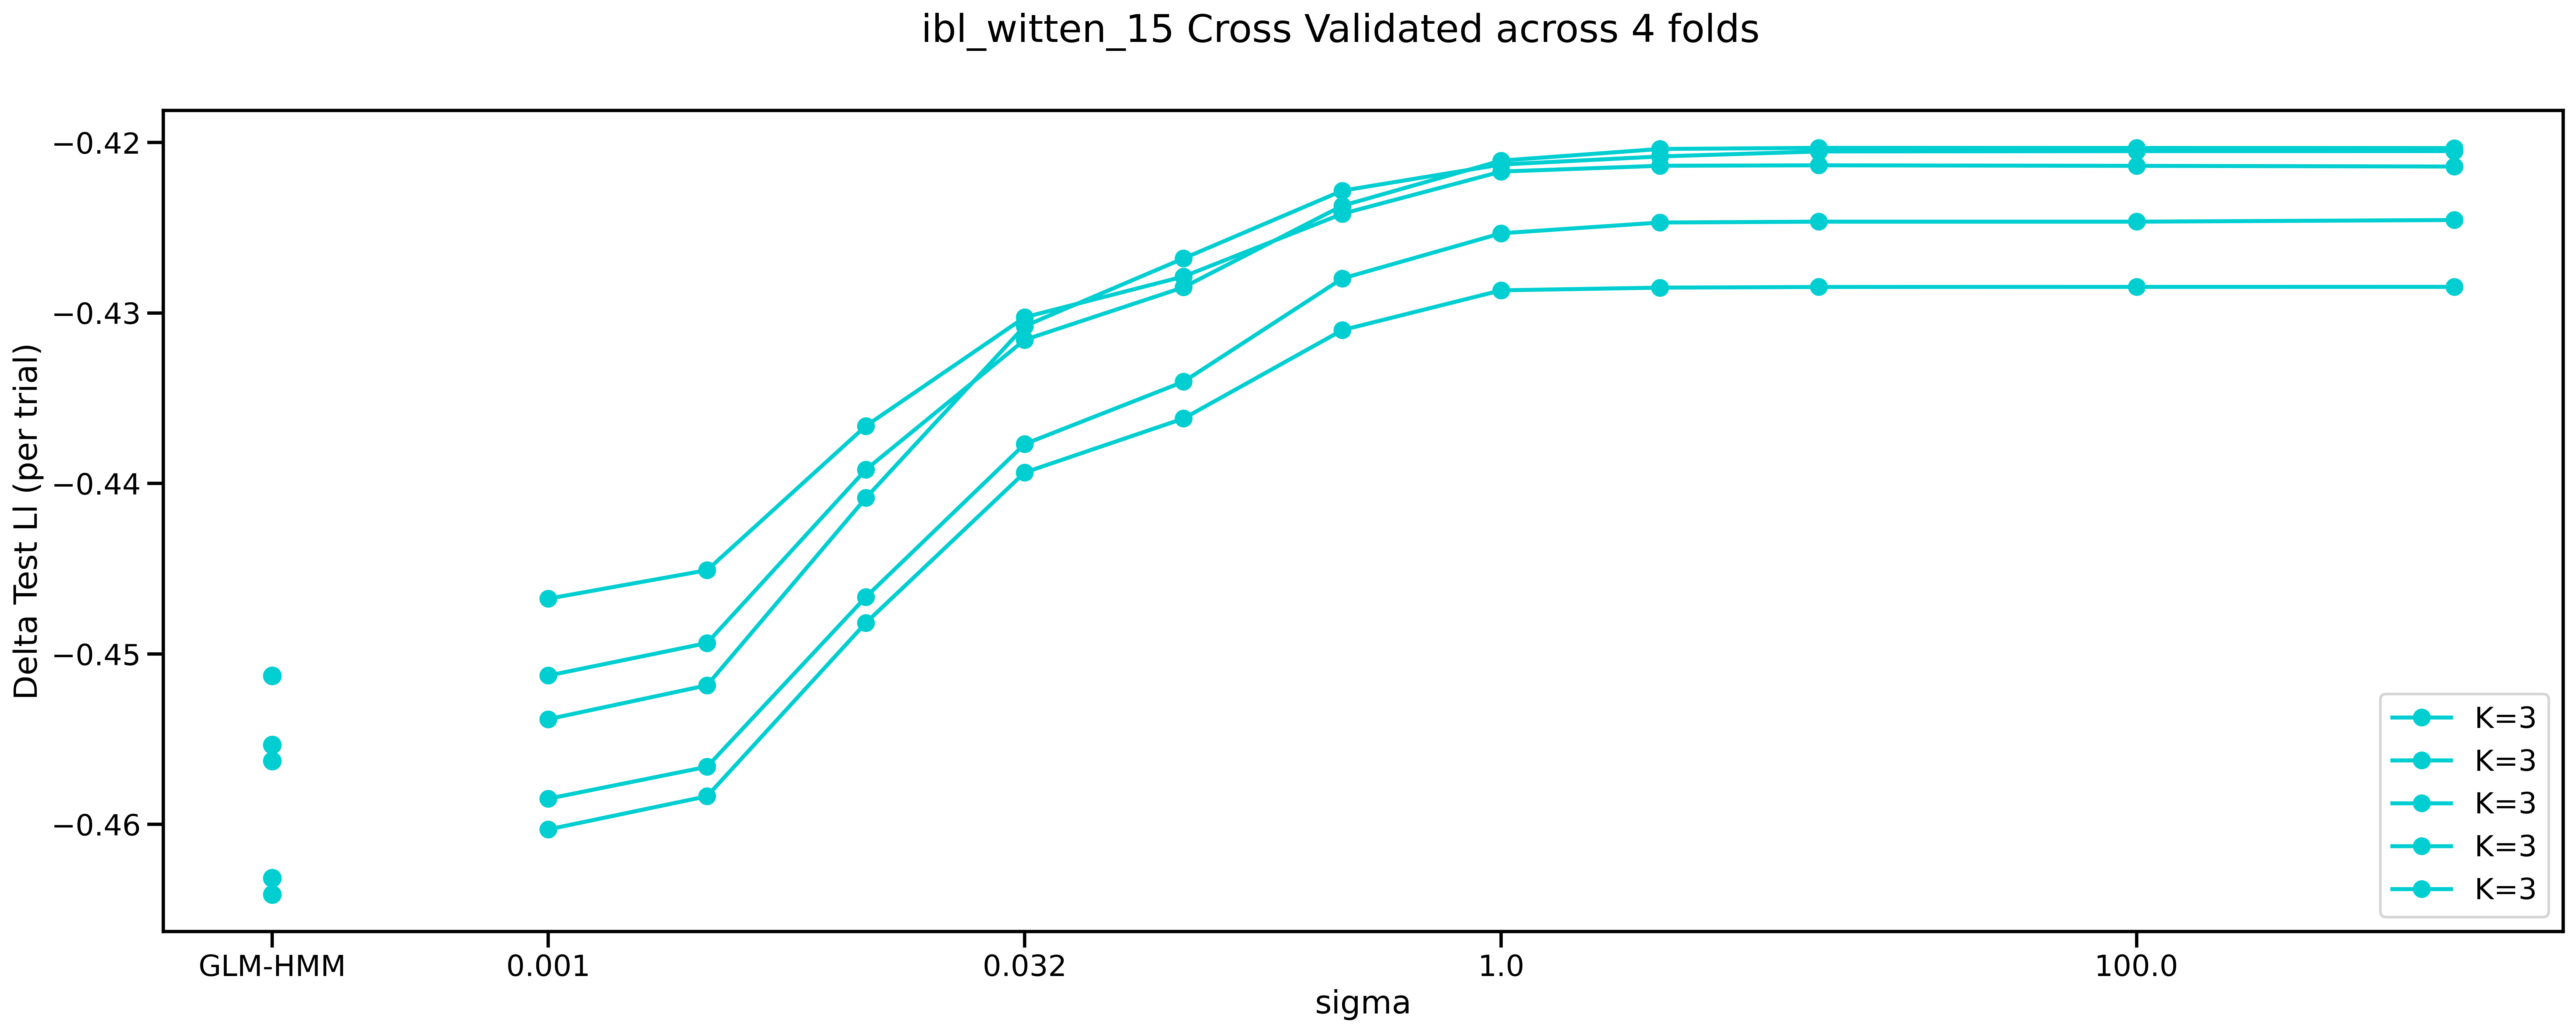

In [96]:
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject} Cross Validated across 4 folds')
fig.tight_layout()
K = 3
for fold in range(0,splitFolds):
    plot_testLl_CV_sigma(testL[fold], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
axes.set_ylabel("Delta Test Ll (per trial)")

Text(762.4583333333334, 0.5, 'Delta Test Ll (per trial)')

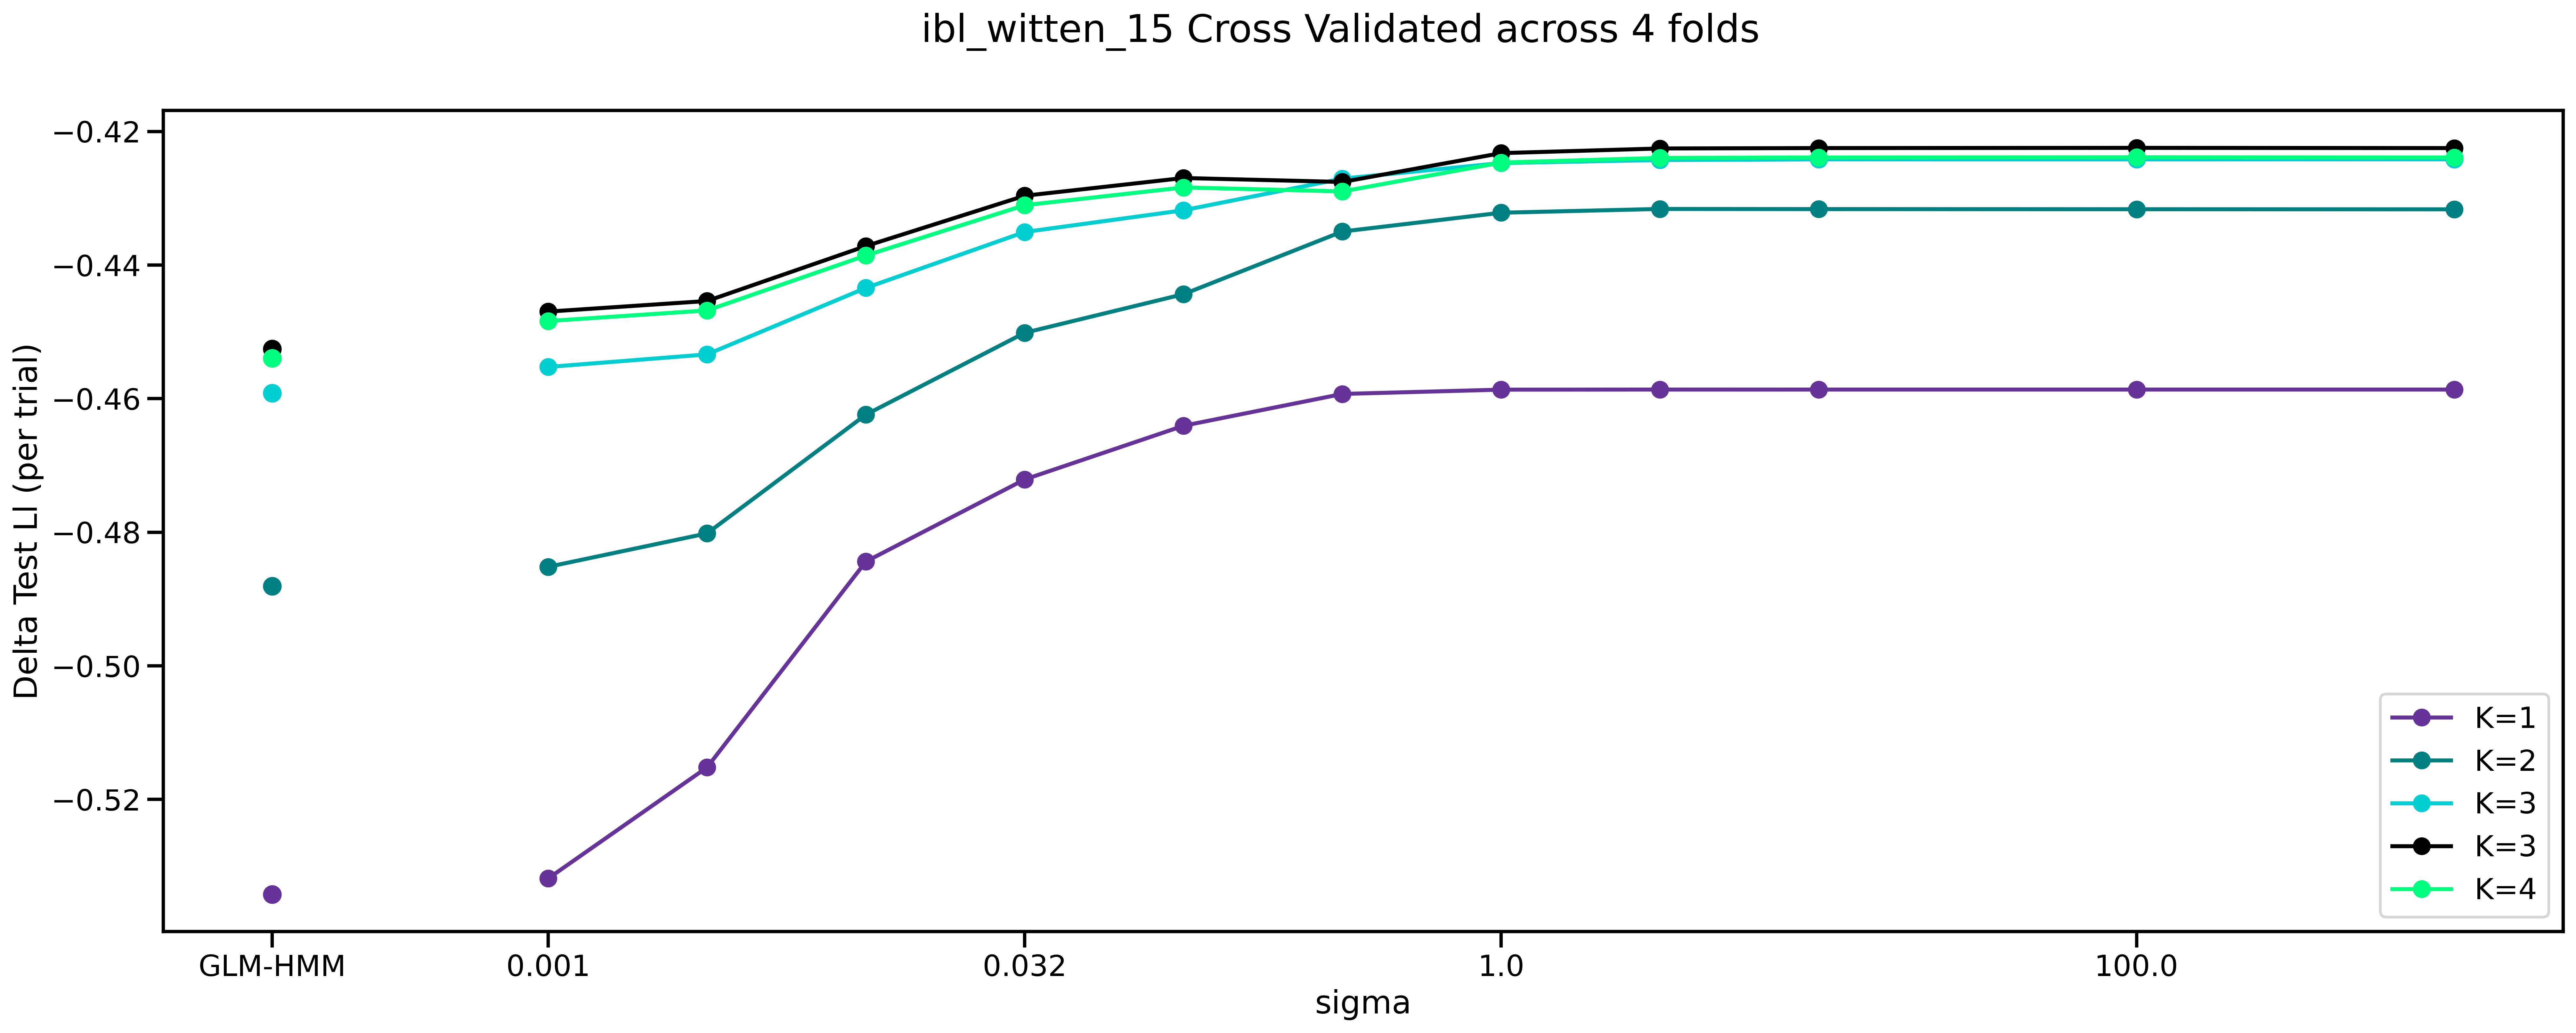

In [101]:
fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
fig.suptitle(f'{subject} Cross Validated across 4 folds')
fig.tight_layout()
for K in range(1,5):
    plot_testLl_CV_sigma(avgTestLl[K-1], sigmaList=sigmaList, label=f'K={K}', color=colormap[K-1], axes=axes)
    if (K==3):
        plot_testLl_CV_sigma(np.mean(testL,axis=0), sigmaList=sigmaList, label=f'K={K}', color='black', axes=axes)
axes.set_ylabel("Delta Test Ll (per trial)")

In [19]:
print(avgTestLl1)

[array([0.        , 0.0036871 , 0.00996022, 0.026651  , 0.03676444,
       0.04169553, 0.04626794, 0.04879351, 0.04922661, 0.04925855,
       0.04926138, 0.04924704]), array([0.        , 0.0036871 , 0.00996022, 0.026651  , 0.03676444,
       0.04169553, 0.04626794, 0.04879351, 0.04922661, 0.04925855,
       0.04926138, 0.04924704]), array([0.        , 0.0036871 , 0.00996022, 0.026651  , 0.03676444,
       0.04169553, 0.04626794, 0.04879351, 0.04922661, 0.04925855,
       0.04926138, 0.04924704]), array([0.        , 0.0036871 , 0.00996022, 0.026651  , 0.03676444,
       0.04169553, 0.04626794, 0.04879351, 0.04922661, 0.04925855,
       0.04926138, 0.04924704])]


In [3]:
priorDirP = [10,1]
print(f'priorDirP={priorDirP}')

priorDirP=[10, 1]
